## Deep Reinforcement Learning
## Lecture / Lab #3

This tutorial was adapted from DRL tutorial @ EEML ( Eastern European Machine Learning Summer School 2019, https://www.eeml.eu/home ), with permission.

Credits to Diana Borsa, Hado van Hasselt, and Matteo Hessel.

## Content

In this tutorial, we will investigate the properties of 3 distinct reinforcement learning algorithms:

* Policy Evaluation
* Online Control: SARSA, Q-learning
* Experience Replay

Some dimensions of the RL problems we will be considering:
* Tabular reinforcement learning
* Off-policy/On-policy Control
* Online vs Replay
* Exploration vs Explotation


## Preliminary notes

You will use Python to implement several reinforcement learning algorithms.
In this tutorial, we are going to work in a *tabular* context, whereby value and action-value functions are represented using arrays or matrices, with a component for each state in the environment / MDP.

You will then run these algorithms on a few problems, to understand their properties and different emerging behaviour. In this tutorial we will focus primary on fundamental algorithms in RL and explore them in a simple gridworld setting.

<b>Note that the solution is provided in the cell below each exercise. As such, we strongly advise you to first attempt the exercise yourself without looking ahead.</b>


# Setup

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import itertools

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

from IPython.display import HTML, display

def display_table(data, precision=1):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(np.round(field, precision))
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

C:\Users\tobi1\AppData\Local\Temp\ipykernel_33224\3660056193.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')
C:\Users\tobi1\AppData\Local\Temp\ipykernel_33224\3660056193.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Environments: Grid-Worlds

**(Simple) Tabular Grid-World**

You can visualize the grid worlds we will train our agents on, by running the cells below.
`S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.
Note that the environment is fully deterministic (i.e., taking an action in a given state always results in the same reward and next state!)

We will use three distinct GridWorlds:
* `Grid` tabular grid world with a goal in the top right of the grid
* `AltGrid` tabular grid world with a goal in the bottom left of the grid

In [44]:
#@title Environment: Gridworld Implementation
class Grid(object):

  def __init__(self, discount=0.9, penalty_for_walls=-5):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    # mace
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0, -1,  0,  0, -1],
      [-1,  0,  0,  0, -1,  0,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1], # borders = walls
      [-1,  0,  -1,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._layout_dims = self._layout.shape

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout <= -1, interpolation="nearest")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action): #not open ai 
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [45]:
#@title Alternative Environment: Gridworld (with different goal state)
class AltGrid(Grid):
  
    def __init__(self, discount=0.9, penalty_for_walls=-5):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, 0 ,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount
      self._penalty_for_walls = penalty_for_walls
      self._layout_dims = self._layout.shape

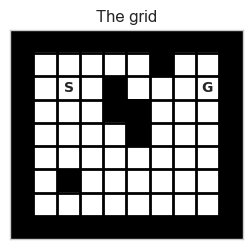

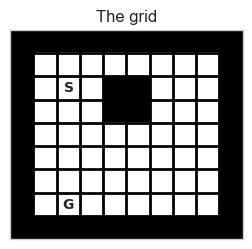

In [46]:
# Visualise the two environments

# Instantiate the two tabular environments
grid = Grid()
alt_grid = AltGrid()

# Plot tabular environments
grid.plot_grid()
alt_grid.plot_grid()

# Policies

We define two fixed policies:
- a *random policy* that selects one of the 4 possible actions at random, with equal probability;
- the $\epsilon$-greedy policy, that selects the action with highest predicted future returns (using a tabular representation of the q-function Q(s,a)) with probability $1-\epsilon$, and a random action with probability $\epsilon$.

In [47]:
#@title Policies (Uniformly random and e-greedy) 
#Expected syntax: `policy(q_values)` 

# uniformly random policy
def random_policy(q):
  return np.random.randint(4)

# epilson-greedy policy
def epsilon_greedy(q_values, epsilon=0.1): #vector of q-values 
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1]) #90% the right one

## Helper functions (for visualization and running experiments)

In [48]:
#@title Helper functions for visualisation

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
      
  
def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)
  

def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

In [49]:
#@title Helper functions for visualizing policies. Policies are represented as arrows pointing in the direction the agent will move from each cell.
def plot_policy(grid, policy):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  grid.plot_grid()
  plt.title('Policy Visualization')
  for i in range(9):
    for j in range(10):
      action_name = action_names[policy[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.title('Greedy Policy')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

## Agent - Environment Interaction 

In [50]:
from tqdm import tqdm

In [51]:
#@title [IMPORTANT] Running the experiments

# Simple interaction loop with the MDP:
# 1) Interact with the environment
# 2) Agent gets observation, rewards, and discount from env. 
# and is expected to produce the next action
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
      
    # Interaction wih the MDP
    for i in tqdm(range(number_of_steps)):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

# RL Lab - Part 1: Tabular Agents

Q-table (Tabular agent) =  
- row = state
- column = action
- entry = q-value (expected return)

Each agent, should implement a step function:

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

Note: All agents should be in pure Python, no TensorFlow needed for this part.

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using $\gamma \cdot \text{v(next_observation)})$ (for whatever definition of v is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `q_values()`:

Tabular agents implement a function `q_values()` returning a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As a convention, we will use the action `0` (which corresponds to `up`) as initial action.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```



## 1.0: Overview

We are going to implement:
- Prediction problem: Policy Evaluation
- Towards control: Greedy Improvement 
- Online Tabular SARSA Agent
- Online Tabular Q-learning Agent
- Tabular Experience Replay Q-learning Agent








## 1.1: Policy evaluation and Greedy Improvement

The purpose here is to evaluate a given policy $\pi$ -- compute the value function assoicated with following/employing this policy in a given MDP.

$$ Q^{\pi}(s, a) = \mathbb{E}_\pi [G_0 | S_0=s,A_0=a]$$

Algorithm:

**Initialize** $Q(s, a)$ for all s ∈ $\mathcal{S}$ and a ∈ $\mathcal{A}(s)$

**Loop forever** (interact with the environment using policy $\pi$ to collect experiences (S,A,R,S') ):

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{behaviour_policy}(S)$
 
3. Take action $A$; observe resulting reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma Q(S', \pi(S')) − Q(S, A))$
- Alpha = monte carlo

# learned about policy evaluation:
- Value and q function are also function of a policy ()

In [52]:
#@title [Coding Task] Policy Evaluation AGENT
# EXERCISE: fill in the code below;  the solution is given in the next cell.
class PolicyEval_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      evaluated_policy, 
      behaviour_policy=random_policy, 
      step_size=0.1):
    self._action = 0
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    
    # ============ YOUR CODE HERE =============
    # initialize your q-values (this is a table of state and action pairs
    # Note: this can be random, but the code was tested w/ zero-initialization 
    self._q = np.zeros(number_of_states, number_of_action)
    pass
  
  # private attributes
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    next_q_values = 
  
    # Get the action to send to execute in the environment and return it
    self._action = self._behaviour_policy(next_q_values)
    self._state = next_s


    return self._action
    

SyntaxError: invalid syntax (3644146885.py, line 38)

In [53]:
#@title Solution: Policy Evaluation AGENT
class PolicyEval_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, evaluated_policy, 
      behaviour_policy=random_policy, step_size=0.1): 
    self._action = 0
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    self._q = np.zeros((number_of_states, number_of_actions))
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    next_a = self._evaluated_policy(self._q[next_s])

    # Online Q-value update
    td_error = r + g * self._q[next_s, next_a] - self._q[s, a]
    self._q[s, a] += self._step_size * td_error

    # Act
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    return self._action

**Task 1**: Run the policy evaluation agent, evaluating the uniformly random policy  on the AltGrid() environment for $\texttt{num_steps} = 1e3, 1e5$. 

Visualise the resulting value functions $Q(s,a)$. Plotting function is provided for you and it takes in a table of q-values

100%|██████████| 100000/100000 [00:02<00:00, 45482.52it/s]


AFTER 100000 STEPS ...


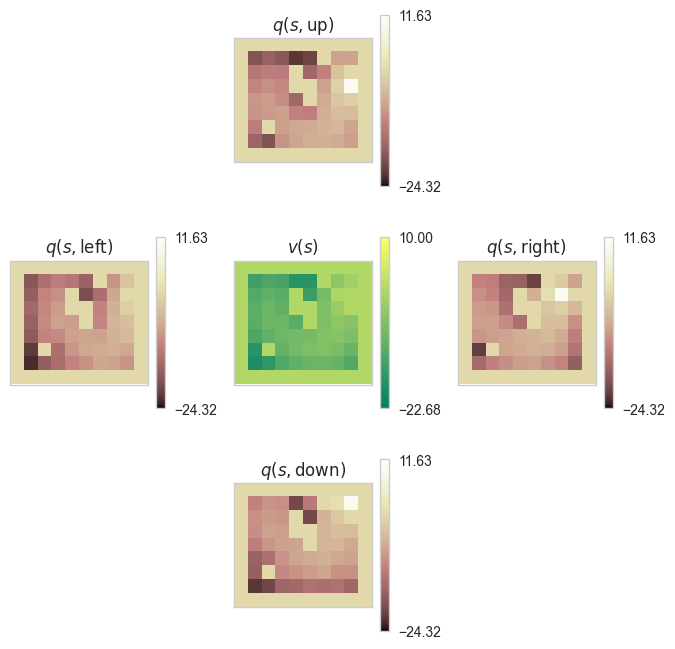

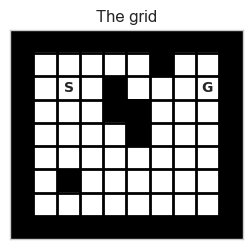

In [54]:
num_steps = int(1e5) # @param

# environment
#grid = AltGrid()
grid = Grid()

# agent 
agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=1.)

grid.plot_grid() 
# q function for each function
# actual value function middle (highest expected reward) (maximum of all other 4) # currently low expected value
# poilicy is random -> starting in moiddle top -> bumping into wall is possible # 

**Task 2: [Greedy Policy Improvement]** Compute and Visualise the greedy policy based on the above evaluation, at the end of the training process for $\texttt{num_steps} = 1e5$.


$$ \pi_{greedy} (a|s) = \arg\max_a Q(s,a) $$


**Q: ** What do you observe? (Remember that we are evaluating the uniformly random policy)

Estimated value function, for reference:


None


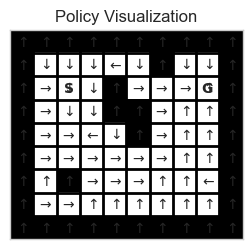

In [55]:
# visualize the greedy policy (whatever works for you, 
# but you should be able to see what the agent would do
# at each step/state).

pi = np.zeros(grid._layout_dims, dtype=np.int32)
for i in range(grid._layout_dims[0]):
  for j in range(grid._layout_dims[1]):
    pi[i, j] = epsilon_greedy(q[i, j], epsilon=0.) # Greedy policy, $\epsilon=0$
# no more random actions ->    

plot_policy(grid, pi)

print("Estimated value function, for reference:") # greedy = select highest probabiliy
value = np.max(q,-1)
print(display_table(value))

**Task 3**: Re-run the same experiment: policy evaluation agent on the Grid() environment for $\texttt{num_steps} = 1e5$
and visualise the resulting value functions and the greedy policy on top of these values at the end of training.

**Q: ** What do you observe? 
- How does this policy compare with the optimal one?
- Try running the training process longer -- what do you observe?

100%|██████████| 100000/100000 [00:02<00:00, 44780.22it/s]


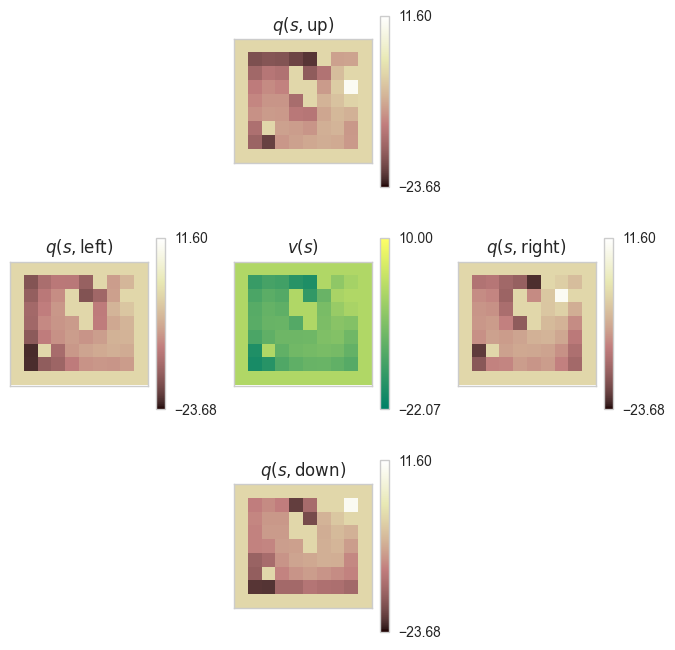

In [56]:
num_steps = int(1e5) # @param

grid = Grid()

agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
plot_action_values(q, epsilon=1.)

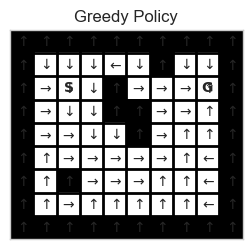

In [57]:
# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.2 On-policy control: SARSA Agent
- converges to the actual best
In the following we are going to be concern with the control problem -- inferring the **optimal value/policy** that will 'solve' the MDP. The first algorithm we are going to be looking at is SARSA. 

Note: This is an **on-policy algoritm** -- i.e: the data collection is done on-policy.


**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{current_policy}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma Q(S', A') − Q(S, A))$

Note that now we are using A' to get the estimate of the next state-action value!

- SARSA is on-policy 
- Q-learning is off-policy (does not need the current policy to learn)
    - TD Learning!

In [58]:
#@title [Coding Task] SARSA Agent
# EXERCISE: solution given in the cell below.
class SARSA_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._action = 0
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    # td_error =
    # self._q[s, a] =
    pass
  
    # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

In [59]:
#@title Solution: SARSA Agent
class SARSA_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state,
      behaviour_policy, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._action = 0
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    next_a = self._behaviour_policy(self._q[next_s])
    
    # Online Q-value update
    td_error = r + g * self._q[next_s, next_a] - self._q[s, a]
    self._q[s, a] += self._step_size * td_error

    # Act
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    return self._action

**Task**: Run the SARSA agent with different levels of exploration. 

- Moderate exploration: $\texttt{epsilon} = 0.1$. 

- Very exploratory strategy: $\texttt{epsilon} = 0.5, 1.0$.

**Q**: Which do you expect, without running the experiment, to do better?  

 **Run multiple times**: What do you observe? ($\texttt{epsilon} = 0.1$)




100%|██████████| 1000000/1000000 [00:27<00:00, 36096.88it/s]


AFTER 1000000 STEPS ...


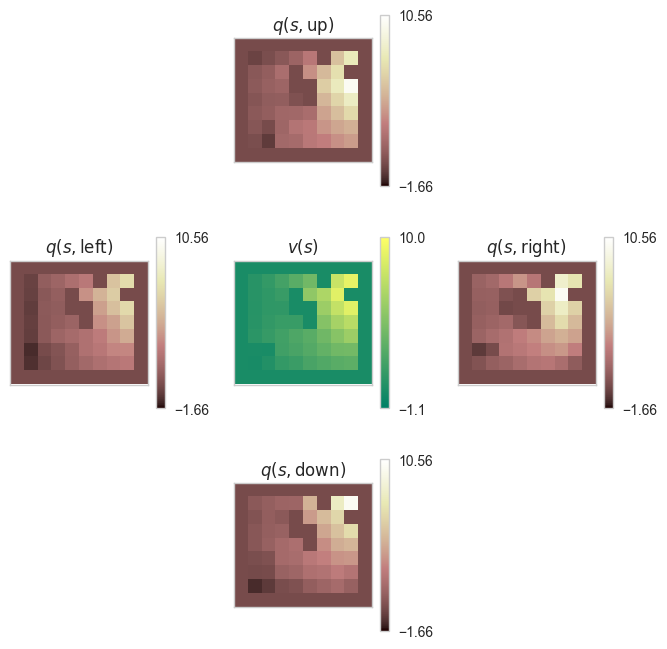

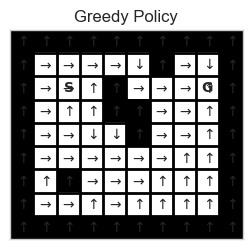

In [60]:
epsilon = 0.5 #@param
num_steps = int(1e6) #@param

# not explore enough = does not find all paths

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = SARSA_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)

# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.3 Off-policy control: Q-learning Agent

Reminder: Q-learning is a very powerful and general algorithm, that enable control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{behaviour_policy}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

Note that this time we take the maximum possible next Q value in state S'.


In [61]:
#@title [Coding Task] Q-learning AGENT
# EXERCISE: solution in the cell below.
class QLearning_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    pass
    
  @property
  def q_values(self):
    pass

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    pass
  
    # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

In [62]:
#@title Solution: Q-learning AGENT
class Qlearning_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state,
      behaviour_policy, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._action = 0

    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    next_a = self._behaviour_policy(self._q[next_s])
    
    # Online Q-value update
    td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
    self._q[s, a] += self._step_size * td_error

    # Act
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    return self._action

### Task 1: Run your Q-learning agent on the below environment for 1e5 number of steps
Keep the rest, to the default values, for this first step. I'll get to experiment with this later.

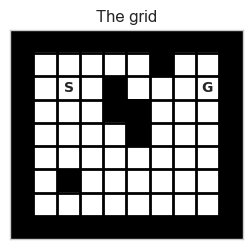

In [69]:
# enviroment
grid = Grid(discount=0.9, penalty_for_walls=-1.) # 1 to 0.01 to 0.0001
grid.plot_grid()

100%|██████████| 100000/100000 [00:04<00:00, 23680.64it/s]


AFTER 100000 STEPS ...


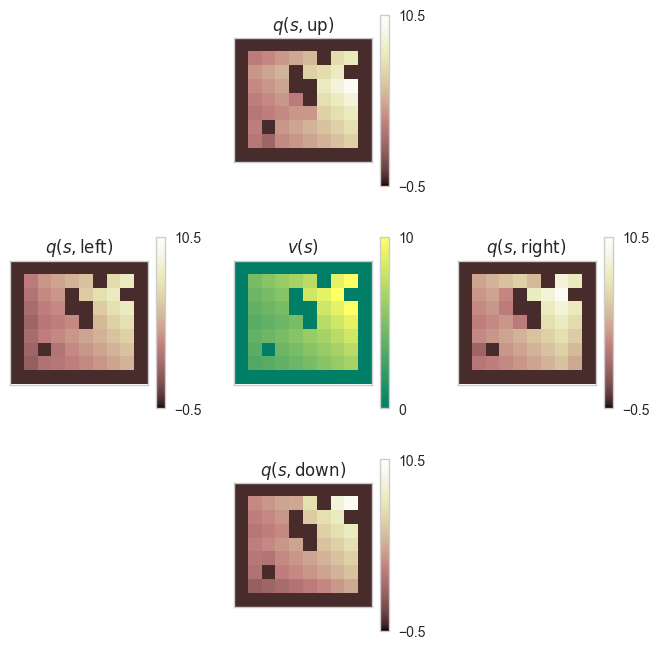

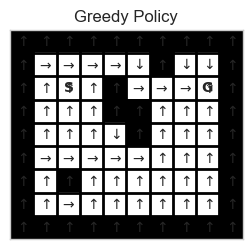

In [72]:
epsilon = 0.9 #@param
num_steps = int(1e5) #@param

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = Qlearning_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=0.)

# visualise the greedy policy
plot_greedy_policy(grid, q)

### Task 2: Experiment with different levels of 'greediness':
* The default was $\epsilon=1$, what does this correspond to?
* Try also $\epsilon =0.1, 0.5$. What do you observe? Does the behaviour policy affect the training in any way?

## 1.4 Experience Replay

 Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled from the *replay buffer* (in addition to the online updates).

**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [22]:
#@title [Coding Task] Q-learning AGENT with a simple replay buffer
# EXERCISE: solution in the cell below.
class ReplayQ_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._num_offline_updates = num_offline_updates
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    
    # initialise replay buffer
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # Online Q-value update
    td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
    self._q[s, a] += self._step_size * td_error
    
    # ============ YOUR CODE HERE =============
    if self._num_offline_updates > 0:

      # Store sample into replay buffer memory
      
    
      # ============ YOUR CODE HERE =============
      # Q-value table update based on online sample and offline samples
      # This update is the same as the above (Q-learning Agent) but 
      # now we are going to be using samples from the replay buffer.
      # Note: You can COPY this from the above Q_learning Agent
      pass

    # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

In [23]:
#@title Solution: Q-learning AGENT with a simple replay buffer 
class ReplayQ_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy=random_policy, 
      num_offline_updates=0, step_size=0.1):
    
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._num_offline_updates = num_offline_updates
    self._step_size = step_size
    self._b = behaviour_policy
    self._action = 0
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # Online Q-value update
    td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
    self._q[s, a] += self._step_size * td_error
    
    if self._num_offline_updates > 0:

      # Non-Parametric-Model Update
      self._replay_buffer.append((s, a, r, g, next_s))

      # Offline Q-value update
      if len(self._replay_buffer) > self._num_offline_updates:
        for i in range(self._num_offline_updates):
          idx = np.random.randint(0, len(self._replay_buffer))
          s, a, r, g, next_s = self._replay_buffer[idx]
          td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
          self._q[s, a] += self._step_size * td_error

    # Act
    self._state = next_state
    self._action = self._b(self._q[next_state])
    return self._action

AFTER 10000 STEPS ...


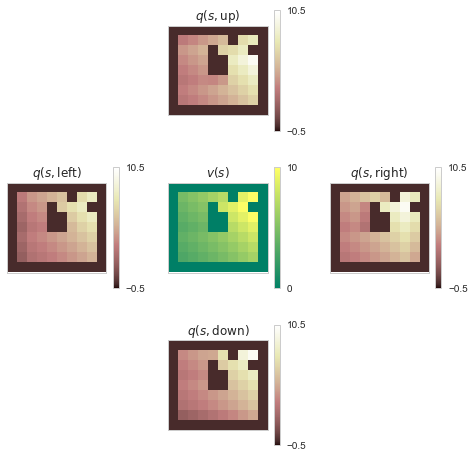

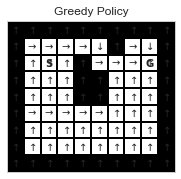

In [24]:
num_offline_updates=30 #@param
num_steps = int(1e4) #@param

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = ReplayQ_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    num_offline_updates=num_offline_updates, 
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.5 Further Analysis:  Data Efficiency

**Online Q-learning**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

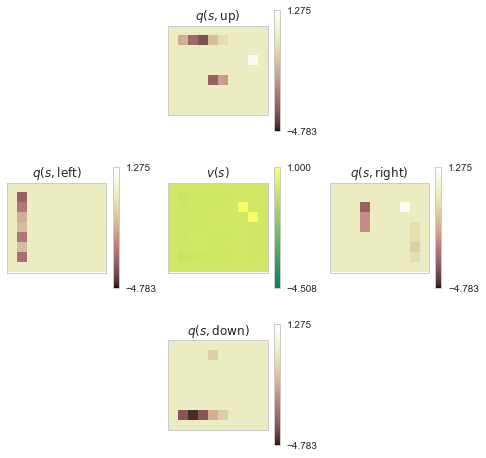

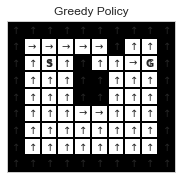

In [25]:
grid = Grid()
agent = ReplayQ_AGENT(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

plot_greedy_policy(grid, q)

**Experience Replay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

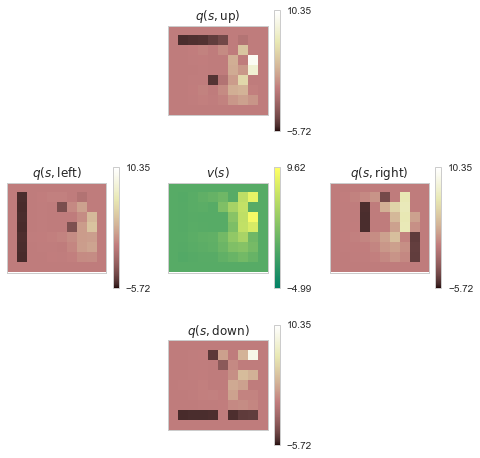

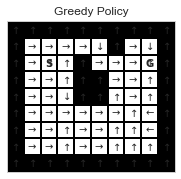

In [26]:
grid = Grid()
agent = ReplayQ_AGENT(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

plot_greedy_policy(grid, q)

### That's a wrap! 
Thank you for going through this tutorial and we hope you found this useful and/or informative. Remember though this is only a starting point, but hopefully one that would inspire more thought and more experimentation in this domain.  As seen throughout this tutorial, 'trial-and-error' can be a very powerful learning mechanism.


"*Negative results are just what I want. They’re just as valuable to me as positive results. I can never find the thing that does the job best until I find the ones that don’t.*” (Thomas Edison)